# L1 и L2 регуляризация. Стохастический и mini-batch градиентный спуск.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight') 
plt.rc('font', size=8)

### L1 регуляризация - Lasso

$\sum^{n}_{i=1}L_i(\vec{x}_i,{y_i},\vec{w}) + \lambda \sum^{m}_{j=1}|w_{j}| \rightarrow \underset{w}{\text{min}}$

In [2]:
def lasso(w, lambda_):
    return lambda_ * np.where(w != 0, w/abs(w), 0)

### L2 регуляризация - Ridge

$\sum^{n}_{i=1}L_i(\vec{x}_i,y_i,\vec{w}) + \lambda \sum^{m}_{j=1}w_{j}^{2} \rightarrow \underset{w}{\text{min}}$

In [3]:
def ridge(w, lambda_):
    return 2 * lambda_ * w

Модифицируем регрессию из прошлого ноутбука

In [4]:
def mse(y_real, y_pred):
    return np.mean((y_real - y_pred)**2)

def r2_score(y_real, y_pred):
    SSres = np.sum((y_real - y_pred)**2)
    SStot = np.sum((y_real - np.mean(y_pred))**2)    
    return 1 - (SSres / SStot)

In [5]:
class LinearRegression:

    def __init__(self,
                 iterations=10000,
                 eta=1e-3,
                 fit_intercept=True,
                 l1_ratio=0,
                 l2_ratio=0,
                 early_stopping_diff=None,
                 weights=None,
                 random_seed=None,
                 verbose=False,
                 history_step=1000,
                 save_coef_history=False):

        self._iterations = iterations
        self._eta = eta
        self._stopping_diff = early_stopping_diff
        self._prev_error = float("inf")
        self._fit_intercept = fit_intercept
        self._data_prepared = False
        self._l1_ratio = l1_ratio
        self._l2_ratio = l2_ratio

        self._w = weights
        self._seed = random_seed

        self._verbose = verbose
        self._history_step = history_step
        self._save_coef = save_coef_history
        self.clear_history()

    @property
    def history(self):
        return pd.DataFrame(self._history)

    @property
    def coef_(self):
        return self._w.copy()
    
    @property
    def coef_history(self):
        return self._coef_history.copy()
        
    def fit(self, X, y):
        X, y = self._prepare_data(X, y)
        self._init_weights(X.shape[1])
        self._data_prepared = True
        self._save_history(X, y)

        for epoch in range(self._iterations):
            y_pred = self._gradient_descent(X, y)
            if self._early_stopping(y, y_pred):
                break

            if epoch % self._history_step == 0 and epoch > 0:
                self._save_history(X, y)

        self._save_history(X, y)
        self._data_prepared = False
        return self.history

    def predict(self, X):
        return self._prepare_data(X) @ self._w

    def _gradient_descent(self, X, y):
        y_pred = self.predict(X)
        grad = 2/len(y) * (X.T @ (y_pred - y))

        penalty = lasso(self._w, self._l1_ratio)
        penalty += ridge(self._w, self._l2_ratio)

        self._w -= self._eta * grad + penalty
        return y_pred

    def _prepare_data(self, X, y=None):
        X = np.array(X)
        if not self._data_prepared:
            if len(X.shape) != 2:
                raise ValueError("Wrong X shape (len(X.shape) != 2)!")

            if self._fit_intercept:
                intercept = np.ones((X.shape[0], 1))
                X = np.hstack((intercept, X))

        if y is None:
            return X

        y = np.array(y)
        return X, y

    def _init_weights(self, size):
        if self._w is None:
            np.random.seed(self._seed)
            self._w = np.random.rand(size)
            self.clear_history()

    def _early_stopping(self, y_real, y_pred):
        if self._stopping_diff is not None:
            error = mse(y_real, y_pred)
            if abs(error - self._prev_error) < self._stopping_diff:
                return True

            self._prev_error = error

        return False    

    def clear_history(self):
        self._history = {"step": [], "loss": [], "r2_score": []}
        self._coef_history = None

    def _save_history(self, X, y_real):
        y_pred = self.predict(X)

        step = len(self._history["step"])
        loss = mse(y_real, y_pred)
        r2 = r2_score(y_real, y_pred)

        self._history["step"].append(step)
        self._history["loss"].append(loss)
        self._history["r2_score"].append(r2)

        if self._save_coef:
            if self._coef_history is None:
                self._coef_history = self.coef_

            self._coef_history = np.vstack(
                (self._coef_history, self.coef_)
            )

        if self._verbose:
            message = f"Step: {step};"
            message += f" loss: {round(loss, 6)};"
            message += f" r2_score: {round(r2, 6)};"
            print(message)

## Stochastic Gradient Descent

In [6]:
class StochasticLinearRegression(LinearRegression):

    def fit(self, X, y):
        X, y = self._prepare_data(X, y)
        self._init_weights(X.shape[1])
        self._data_prepared = True
        self._save_history(X, y)

        rand_indexes = np.random.randint(len(y), size=(self._iterations,))
        for epoch, idx in enumerate(rand_indexes):
            self._gradient_descent(X[idx:idx+1], y[idx:idx+1])

            if self._stopping_diff is not None and epoch % 100:
                y_pred = self.predict(X)
                if self._early_stopping(y, y_pred):
                    break
            
            if epoch % self._history_step == 0 and epoch > 0:
                self._save_history(X, y)

        self._save_history(X, y)
        self._data_prepared = False
        return self.history

## Mini-Batch Gradient Descent

In [7]:
class DataLoader:
    
    def __init__(self, dataset, y=None, batch_size=1, shuffle=False, random_state=None):
        self._dataset = np.array(dataset)        
        self._y = y
        self._indexes = np.arange(dataset.shape[0])
        self._batch_size = batch_size
        
        if self._y is not None:
            self._y = np.array(self._y)
            if self._y.shape[0] != self._dataset.shape[0]:
                error = 'X and y has different row count'
                error += f' ({self._dataset.shape[0]} != {self._y.shape[0]})'
                raise ValueError(error)

        np.random.seed(random_state)
        if shuffle:
            np.random.shuffle(self._indexes)

        self._get_batch_count()

    def __len__(self):
        return self._batch_count

    def __getitem__(self, index):
        if index < 0 or index >= len(self):
            raise IndexError(f'Index {index} is out of bounds [0, {len(self)-1}]')

        start = self._batch_size * (index)
        end = self._batch_size * (index + 1)
        idx = self._indexes[start:end]
        
        if self._y is not None:
            return self._dataset[idx, ...], self._y[idx, ...]
        
        return self._dataset[idx, ...]

    def _get_batch_count(self):
        n = self._dataset.shape[0]
        self._batch_count = n // self._batch_size
        if n % self._batch_count != 0:
            self._batch_count += 1

In [8]:
class MiniBatchLinearRegression(LinearRegression):
    
    def __init__(self, batch_size=32, **kwargs):
        self._batch_size=batch_size
        super().__init__(**kwargs)

    def fit(self, X, y):
        X, y = self._prepare_data(X, y)
        self._init_weights(X.shape[1])
        self._data_prepared = True
        self._save_history(X, y)

        loader = DataLoader(X, y, batch_size=self._batch_size)
        for epoch in range(self._iterations):
            for batch_X, batch_y in loader:
                self._gradient_descent(batch_X, batch_y)

            if self._stopping_diff is not None:
                y_pred = self.predict(X)
                if self._early_stopping(y, y_pred):
                    break

            if epoch % self._history_step == 0 and epoch > 0:
                self._save_history(X, y)

        self._save_history(X, y)
        self._data_prepared = False
        return self.history

## А теперь посмотрим как эти модели работают

In [9]:
def plot_history(history, label=""):
    loss = history['loss'][len(history)-1]
    plt.plot(history["step"], history["loss"], alpha=0.7, label=label)
    plt.ylabel("Loss")
    plt.xlabel("Step")

In [10]:
from sklearn import datasets
X, y, coef = datasets.make_regression(n_samples=1000, 
                                      n_features=2, 
                                      n_informative=2,
                                      n_targets=1,
                                      noise=5, 
                                      bias=0, # intersept=0   
                                      coef=True, 
                                      random_state=42)

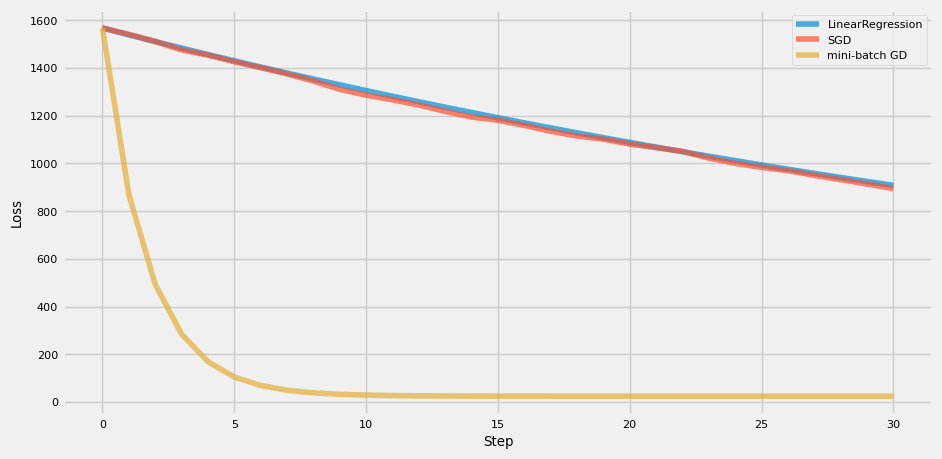

In [11]:
eta = 1e-4
plt.figure(figsize=(10, 5))

lr = LinearRegression(iterations=1500, eta=eta, history_step=50, random_seed=64)
sgd_lr = StochasticLinearRegression(iterations=1500, eta=eta, history_step=50, random_seed=64)
mb_lr = MiniBatchLinearRegression(iterations=1500, eta=eta, history_step=50, batch_size=32, random_seed=64)

plot_history(lr.fit(X, y), 'LinearRegression')
plot_history(sgd_lr.fit(X, y), "SGD")
plot_history(mb_lr.fit(X, y), 'mini-batch GD')

plt.grid(True)
plt.legend()
plt.show()

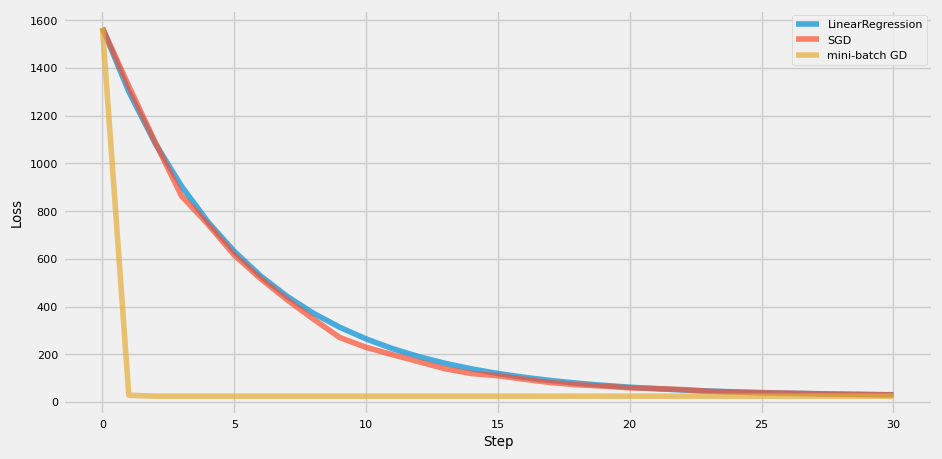

In [12]:
eta = 1e-3
plt.figure(figsize=(10, 5))

lr = LinearRegression(iterations=1500, eta=eta, history_step=50, random_seed=64)
sgd_lr = StochasticLinearRegression(iterations=1500, eta=eta, history_step=50, random_seed=64)
mb_lr = MiniBatchLinearRegression(iterations=1500, eta=eta, history_step=50, batch_size=32, random_seed=64)

plot_history(lr.fit(X, y), 'LinearRegression')
plot_history(sgd_lr.fit(X, y), "SGD")
plot_history(mb_lr.fit(X, y), 'mini-batch GD')

plt.grid(True)
plt.legend()
plt.show()

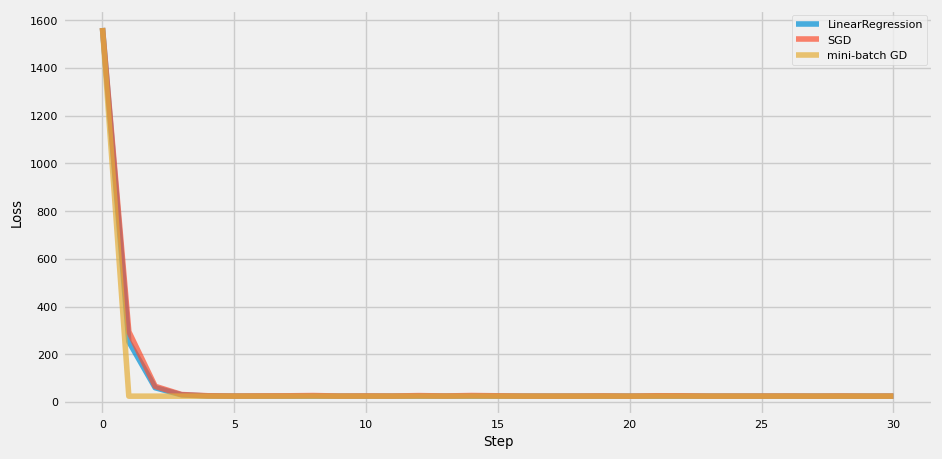

In [13]:
eta = 1e-2
plt.figure(figsize=(10, 5))

lr = LinearRegression(iterations=1500, eta=eta, history_step=50, random_seed=64)
sgd_lr = StochasticLinearRegression(iterations=1500, eta=eta, history_step=50, random_seed=64)
mb_lr = MiniBatchLinearRegression(iterations=1500, eta=eta, history_step=50, batch_size=32, random_seed=64)

plot_history(lr.fit(X, y), 'LinearRegression')
plot_history(sgd_lr.fit(X, y), "SGD")
plot_history(mb_lr.fit(X, y), 'mini-batch GD')

plt.grid(True)
plt.legend()
plt.show()

На графиках видно, что скорость сходимости градиентного спуска и стохастического градиентного спуска примерно одинакова.
Стахастический градиентный спуск имеет неравномерную скорость сходимости.

Mini-batch потребовал значительно меньшее количество итераций, чем остальные алгоритмы. Однако это не значит, что по затраченному времени он будет самым быстрым, особенно на большой выборке. В SGD для каждой итерации расчет видется по одному элементу, а в остальных по всей выборке.

In [14]:
X, y, coef = datasets.make_regression(n_samples=10000, 
                                      n_features=2, 
                                      n_informative=2,
                                      n_targets=1,
                                      noise=5, 
                                      bias=0, # intersept=0   
                                      coef=True, 
                                      random_state=42)

In [15]:
%%time
lr = LinearRegression(iterations=5000, random_seed=64)
lr.fit(X, y);

CPU times: total: 156 ms
Wall time: 160 ms


In [16]:
%%time
lr = StochasticLinearRegression(iterations=5000, random_seed=64)
lr.fit(X, y);

CPU times: total: 31.2 ms
Wall time: 43.5 ms


In [17]:
%%time
lr = MiniBatchLinearRegression(iterations=5000, random_seed=64, batch_size=100,)
lr.fit(X, y);

CPU times: total: 5.7 s
Wall time: 5.71 s


## Посмотрим как L1 и L2 влияют на веса и ошибку

In [18]:
X, y, coef = datasets.make_regression(n_samples=1000, 
                                      n_features=2, 
                                      n_informative=2,
                                      n_targets=1,
                                      noise=5, 
                                      bias=0, # intersept=0   
                                      coef=True, 
                                      random_state=42)

In [19]:
eta=1e-2
iterations = 200

results = {
    'lambda_': [],
    'l1_w0': [], 'l1_w1': [], 'l1_loss': [],
    'l2_w0': [], 'l2_w1': [], 'l2_loss': []
}
for lambda_ in np.logspace(start=-4, stop=-.1, num=20):
    results['lambda_'].append(lambda_)

    lr = LinearRegression(iterations=iterations, eta=eta, random_seed=256, l1_ratio=lambda_)
    history = lr.fit(X, y)
    results['l1_w0'].append(lr.coef_[1])
    results['l1_w1'].append(lr.coef_[2])
    results['l1_loss'].append(history['loss'].values[-1])
    
    lr = LinearRegression(iterations=iterations, eta=eta, random_seed=256, l2_ratio=lambda_)
    history = lr.fit(X, y)
    results['l2_w0'].append(lr.coef_[1])
    results['l2_w1'].append(lr.coef_[2])
    results['l2_loss'].append(history['loss'].values[-1])

results = pd.DataFrame(results)

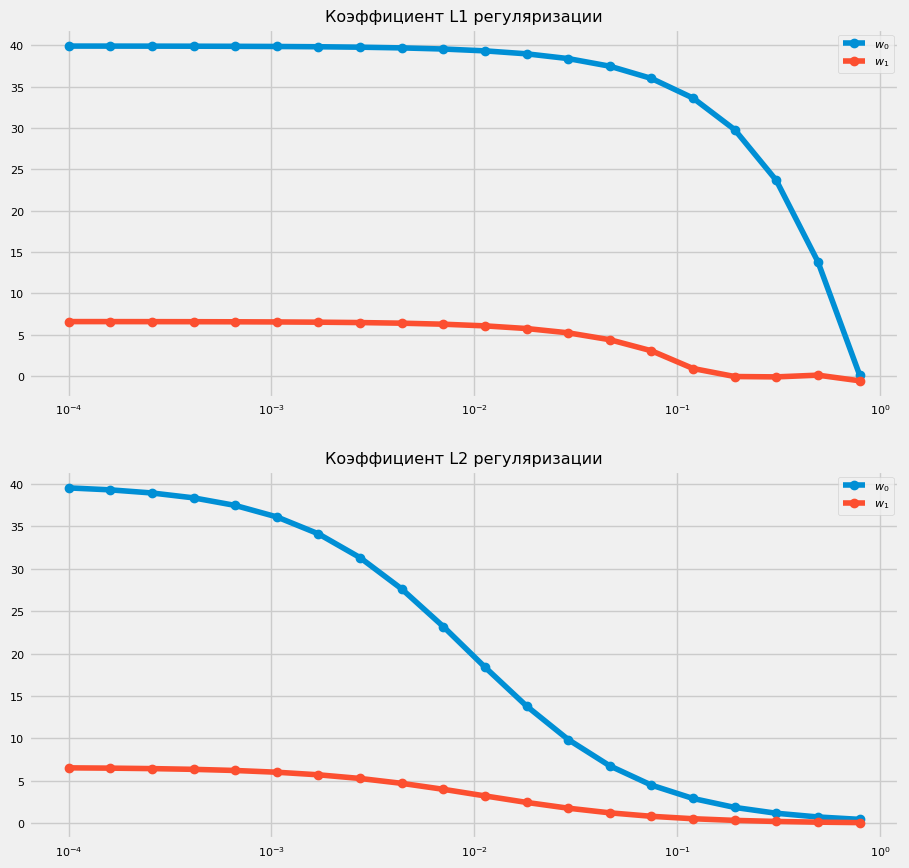

In [20]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(results['lambda_'], results['l1_w0'], 'o-', label='$w_0$')
plt.plot(results['lambda_'], results['l1_w1'], 'o-', label='$w_1$')

plt.title('Коэффициент L1 регуляризации')
plt.xscale('log')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(results['lambda_'], results['l2_w0'], 'o-', label='$w_0$')
plt.plot(results['lambda_'], results['l2_w1'], 'o-', label='$w_1$')
plt.title('Коэффициент L2 регуляризации')
plt.xscale('log')
plt.grid(True)
plt.legend()

plt.show()

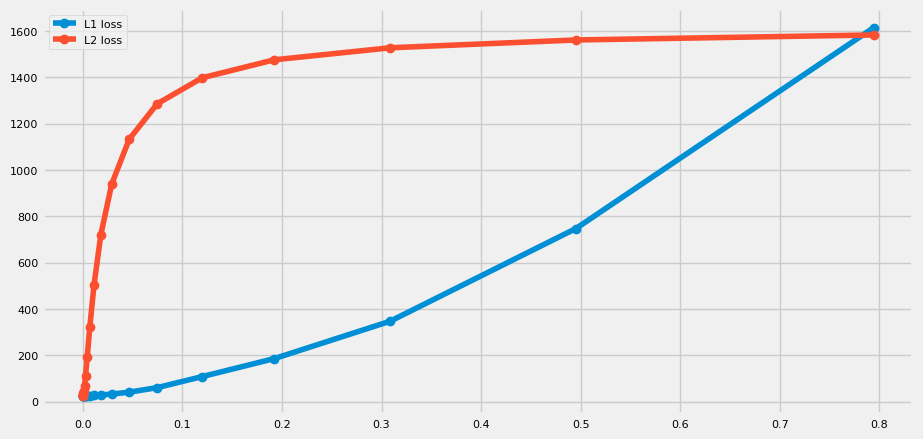

In [21]:
plt.figure(figsize=(10, 5))

plt.plot(results['lambda_'], results['l1_loss'], 'o-', label='L1 loss')
plt.plot(results['lambda_'], results['l2_loss'], 'o-', label='L2 loss')

plt.grid(True)
plt.legend()

plt.show()